In [1]:
# Environment Variables
from dotenv import load_dotenv
load_dotenv("../.env");

# System Modules
from pathlib import Path

# General Purpose Libraries 
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio.v3 as iio

# Paths, Datasets and Datamodules
from etl.pathfactory import PathFactory
from etl.etl import reset_dir
from data.datamodules import ClassificationDataModule
from data.datastreaming import ClassificationStreamingDataset

# Transforms
import torchvision.transforms.v2 as t

# Models
from torchvision.models import alexnet, AlexNet_Weights

# Tasks
from training.tasks import ClassificationTask

# Loggers
import wandb
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import WandbLogger, CSVLogger

#Trainers
from lightning import Trainer

# Type Hints
from typing import Callable, Any, Optional 
from numpy.typing import NDArray

In [2]:
LOGS_DIR = Path.cwd() / "logs"
CHECKPOINTS_DIR = LOGS_DIR / "checkpoints"


In [3]:
val_loss_ckpt = ModelCheckpoint(
    dirpath=CHECKPOINTS_DIR,
    filename="epoch={epoch}-val_loss:{val_loss:2f}",
    monitor="val_loss",
    mode="min",
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
)

csv_logger = CSVLogger(
    save_dir=LOGS_DIR,
    name="csv",
    version=1,
)

#wandb.finish()
wandb_logger = WandbLogger(
    save_dir=LOGS_DIR,
    project="imagenette",
    log_model=False,
    name="alexnet-logging-test",
    version='1',
    offline=True,
)

In [4]:
reset_dir(LOGS_DIR)
reset_dir(CHECKPOINTS_DIR)

In [5]:
experiment = {
    "dataset_name": "imagenette",
    "task": "classification",

    "eval_split": "predefined",
    "batch_size": 128,
    "grad_accum": 4,
    "num_workers": 14,

    "num_classes": 10,
    "loss": "cross_entropy",
    "optimizer": "adam",
    "learning_rate": 1e-5,
    "momentum": 0,
    "weight_decay": 0,
}

imagenette_paths = PathFactory("imagenette", "classification")
imagenet_means = [0.485, 0.456, 0.406]
imagenet_std_devs = [0.229, 0.224, 0.225]

# TODO: Figure out how to do the min-max scaling on every image
image_transform = t.Compose([
    t.ToImage(),
    t.ToDtype(torch.float32, scale=False),
    t.Normalize(imagenet_means, imagenet_std_devs),
    t.Resize((224, 224), antialias=True),
    t.RandomHorizontalFlip(0.5),
    # t.Normalize(mean = eurosat_train_means[3:0:-1],
    # std = eurosat_train_std_devs[3:0:-1]),
    # t.ToDtype(torch.int32, scale = True),
    # t.RandomResizedCrop((64, 64), antialias=True),
    # t.ToDtype(torch.float32, scale = True),
])

datamodule = ClassificationDataModule(
    root = imagenette_paths.shards_url,
    is_remote = True,
    is_sharded = True,
    #dataframe=imagenette_dataframe(imagenette_paths.path),
    dataset = ClassificationStreamingDataset, #type: ignore
    image_transform = image_transform,
    **experiment
)

alexnet_p = alexnet(weights=AlexNet_Weights.DEFAULT)
alexnet_p.classifier[-1] = torch.nn.Linear(4096, experiment.get("num_classes", 10))

trainer = Trainer(
    callbacks = [val_loss_ckpt],
    logger = [csv_logger],
    #logger = [csv_logger, wandb_logger],

    # fast_dev_run = True,
    max_epochs=1,
    check_val_every_n_epoch=1,
    limit_train_batches=30,
    limit_val_batches=10,
    limit_test_batches=10
)

last_ckpt_path = (CHECKPOINTS_DIR / "last.ckpt").as_posix() if (CHECKPOINTS_DIR / "last.ckpt").is_file() else None

s3://classification/shards/imagenette


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [6]:
trainer.fit(
    model=ClassificationTask(alexnet_p, **experiment),
    datamodule=datamodule,
    ckpt_path=last_ckpt_path
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type                      | Params
----------------------------------------------------------------
0 | model             | AlexNet                   | 57.0 M
1 | criterion         | CrossEntropyLoss          | 0     
2 | confusion_matrix  | MulticlassConfusionMatrix | 0     
3 | cohen_kappa       | MulticlassCohenKappa      | 0     
4 | val_metrics       | MetricCollection          | 0     
5 | test_metrics      | MetricCollection          | 0     
6 | classwise_metrics | MetricCollection          | 0     
----------------------------------------------------------------
57.0 M    Trainable params
0         Non-trainable params
57.0 M    Total params
228.179   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/sambhav/miniconda3/envs/dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/sambhav/miniconda3/envs/dev/lib/python3.11/site-packages/lightning/pytorch/utilities/data.py:121: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
/home/sambhav/miniconda3/envs/dev/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/sambhav/miniconda3/envs/dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

/home/sambhav/miniconda3/envs/dev/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/sambhav/miniconda3/envs/dev/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


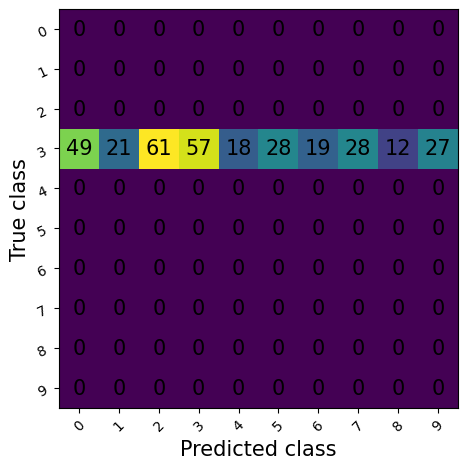

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       1.00      0.18      0.30       320
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

    accuracy                           0.18       320
   macro avg       0.10      0.02      0.03       320
weighted avg       1.00      0.18      0.30       320



/home/sambhav/miniconda3/envs/dev/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sambhav/miniconda3/envs/dev/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sambhav/miniconda3/envs/dev/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     test_cohen_kappa      │            0.0            │
│    test_macro_accuracy    │   0.017812499776482582    │
│     test_macro_auroc      │            0.0            │
│       test_macro_f1       │    0.03023872710764408    │
│   test_macro_precision    │    0.10000000149011612    │
│     test_macro_recall     │   0.017812499776482582    │
└───────────────────────────┴───────────────────────────┘

[{'test_macro_accuracy': 0.017812499776482582,
  'test_macro_auroc': 0.0,
  'test_macro_f1': 0.03023872710764408,
  'test_macro_precision': 0.10000000149011612,
  'test_macro_recall': 0.017812499776482582,
  'test_cohen_kappa': 0.0}]

In [7]:
trainer.test(
    model=ClassificationTask(alexnet_p, **experiment),
    datamodule=datamodule,
    ckpt_path=last_ckpt_path
)

In [8]:
wandb.finish()